# Gru Extract Features Merging Architecture

100%|██████████| 125/125 [02:46<00:00,  1.34s/it]


10005 10005


Epoch 1/10: 100%|██████████| 126/126 [02:47<00:00,  1.33s/it]


Epoch 1 Loss 1.704998
Time taken for 1 epoch 167.86012434959412 sec



Epoch 2/10: 100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch 2 Loss 1.366999
Time taken for 1 epoch 149.91317558288574 sec



Epoch 3/10: 100%|██████████| 126/126 [02:42<00:00,  1.29s/it]


Epoch 3 Loss 1.244969
Time taken for 1 epoch 162.1230821609497 sec



Epoch 4/10: 100%|██████████| 126/126 [02:34<00:00,  1.23s/it]


Epoch 4 Loss 1.148199
Time taken for 1 epoch 154.95731210708618 sec



Epoch 5/10: 100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Epoch 5 Loss 1.067073
Time taken for 1 epoch 150.4077398777008 sec



Epoch 6/10: 100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch 6 Loss 0.999175
Time taken for 1 epoch 149.79678750038147 sec



Epoch 7/10: 100%|██████████| 126/126 [02:32<00:00,  1.21s/it]


Epoch 7 Loss 0.939193
Time taken for 1 epoch 152.9484302997589 sec



Epoch 8/10: 100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Epoch 8 Loss 0.884959
Time taken for 1 epoch 151.24791765213013 sec



Epoch 9/10: 100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch 9 Loss 0.836307
Time taken for 1 epoch 148.9133427143097 sec



Epoch 10/10: 100%|██████████| 126/126 [02:31<00:00,  1.20s/it]

Epoch 10 Loss 0.789830
Time taken for 1 epoch 151.03919219970703 sec



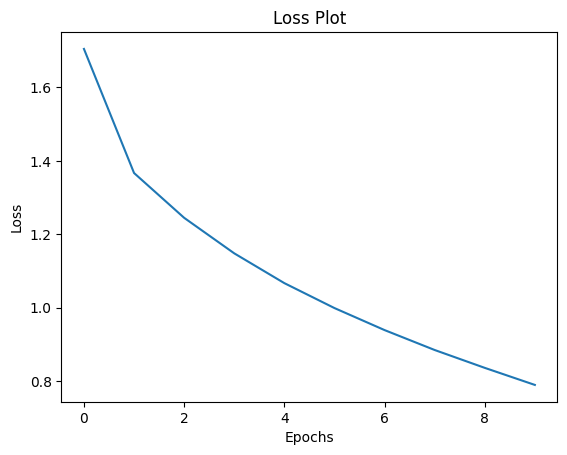

Légende générée :  a woman is talking to be another in a kitchen <end>


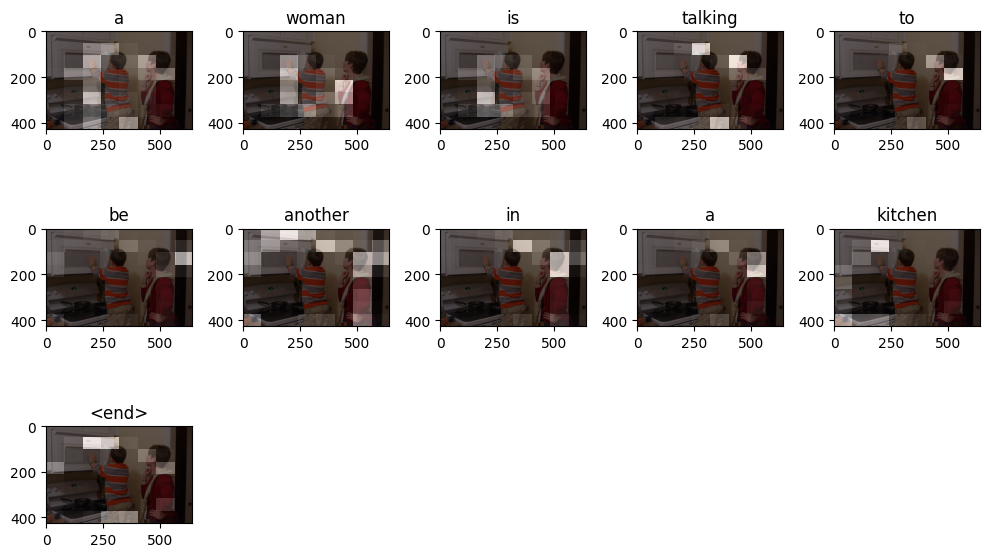

In [18]:
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections

# --- CONFIGURATION ---
base_dir = os.getcwd()
relative_path = r"../../DataSets/Dataset_delivrable_3"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

# Chemin du fichier d'annotations
annotation_folder = os.path.join(dataset_dir, 'annotations')
annotation_file = os.path.join(dataset_dir, 'annotations/captions_train2014.json')

# Chemin du dossier contenant les images à annoter
image_folder = os.path.join(dataset_dir, 'train2014/')
PATH = image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le même identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = val['caption']
    image_path = PATH + '\\COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:6000]

# Liste de toutes les annotations
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

# Ajouter des tokens de début et de fin aux captions
train_captions = ['<start> ' + caption + ' <end>' for caption in train_captions]

top_k = 5000
# Initialisation du tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>")
tokenizer.fit_on_texts(train_captions)

# Vérifier et ajouter le token <start> au vocabulaire si nécessaire
if '<start>' not in tokenizer.word_index:
    tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1

# Modèle ResNet50 pour le prétraitement des images
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
new_input = tf.keras.Input(shape=(299, 299, 3))
hidden_layer = image_model(new_input)
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

# Fonction load_image
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [299, 299])
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

# Fonction pour calculer la longueur maximale des légendes
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Tokenization et padding
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = calc_max_length(train_seqs)

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Fractionnement des datasets en entraînement et validation
img_keys = list(img_to_cap_vector.keys())
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train, cap_train = [], []
for imgt in img_name_train_keys:
    img_name_train.extend([imgt] * len(img_to_cap_vector[imgt]))
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val, cap_val = [], []
for imgv in img_name_val_keys:
    img_name_val.extend([imgv] * len(img_to_cap_vector[imgv]))
    cap_val.extend(img_to_cap_vector[imgv])

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Modèle CNN pour encoder les images
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

# Mécanisme d'attention
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Décodeur RNN avec GRU
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

checkpoint_path = "./checkpoints2/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

EPOCHS = 10
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

def plot_attention(image_path, result, attention_plot):
    temp_image = np.array(Image.open(image_path))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.show()

def evaluate_random_image():
    random_image = random.choice(img_name_val)
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(random_image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[i] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return random_image, result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return random_image, result, attention_plot

random_image, result, attention_plot = evaluate_random_image()
print('Légende générée : ', ' '.join(result))
plot_attention(random_image, result, attention_plot)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
Epoch 1/10: 100%|██████████| 376/376 [17:07<00:00,  2.73s/it]


Epoch 1 Loss 0.985027
Time taken for 1 epoch 1027.6350824832916 sec



Epoch 2/10: 100%|██████████| 376/376 [15:53<00:00,  2.53s/it]


Epoch 2 Loss 0.791932
Time taken for 1 epoch 953.0885684490204 sec



Epoch 3/10: 100%|██████████| 376/376 [15:36<00:00,  2.49s/it]


Epoch 3 Loss 0.719057
Time taken for 1 epoch 936.0457882881165 sec



Epoch 4/10: 100%|██████████| 376/376 [19:37<00:00,  3.13s/it]


Epoch 4 Loss 0.665215
Time taken for 1 epoch 1177.5256383419037 sec



Epoch 5/10: 100%|██████████| 376/376 [16:03<00:00,  2.56s/it]


Epoch 5 Loss 0.620711
Time taken for 1 epoch 963.7993957996368 sec



Epoch 6/10: 100%|██████████| 376/376 [16:06<00:00,  2.57s/it]


Epoch 6 Loss 0.582394
Time taken for 1 epoch 966.8500289916992 sec



Epoch 7/10: 100%|██████████| 376/376 [15:54<00:00,  2.54s/it]


Epoch 7 Loss 0.544911
Time taken for 1 epoch 954.327757358551 sec



Epoch 8/10: 100%|██████████| 376/376 [16:08<00:00,  2.58s/it]


Epoch 8 Loss 0.510221
Time taken for 1 epoch 968.4232652187347 sec



Epoch 9/10: 100%|██████████| 376/376 [16:01<00:00,  2.56s/it]


Epoch 9 Loss 0.480395
Time taken for 1 epoch 961.5228624343872 sec



Epoch 10/10: 100%|██████████| 376/376 [16:35<00:00,  2.65s/it]

Epoch 10 Loss 0.450594
Time taken for 1 epoch 995.0474376678467 sec



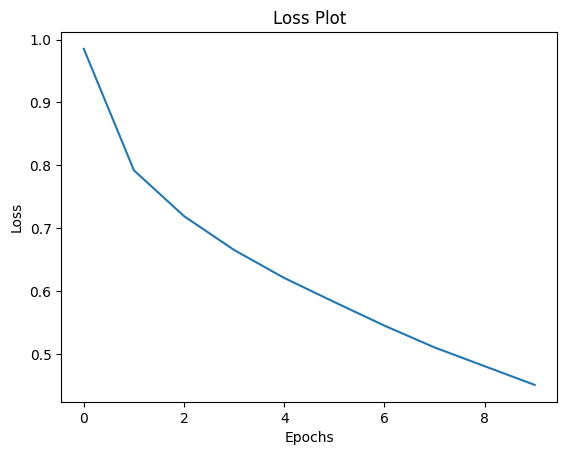

Légende générée :  a bathroom with a toilet and a towel rack <end>


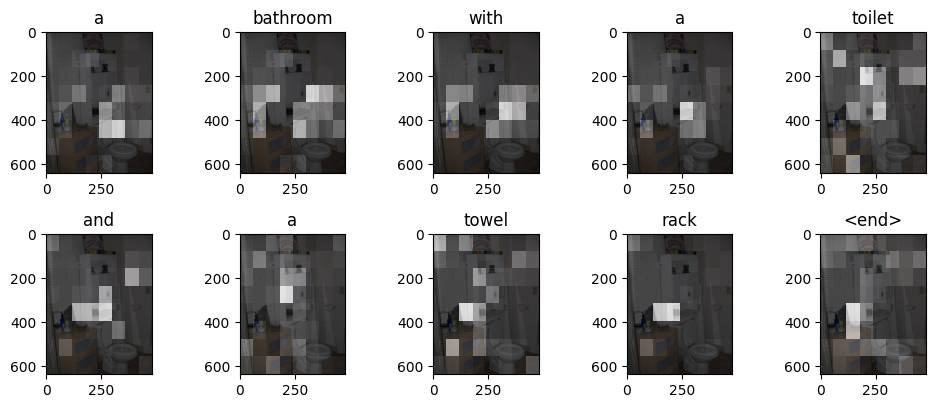

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\steve/nltk_data'
    - 'c:\\Users\\steve\\Documents\\GitHub\\DataSciencePictureDesc\\data-science\\nltk_data'
    - 'c:\\Users\\steve\\Documents\\GitHub\\DataSciencePictureDesc\\data-science\\share\\nltk_data'
    - 'c:\\Users\\steve\\Documents\\GitHub\\DataSciencePictureDesc\\data-science\\lib\\nltk_data'
    - 'C:\\Users\\steve\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu  # Import for BLEU score calculation

nltk.download('punkt')  # Download NLTK data for tokenization if not already present

# --- CONFIGURATION ---
base_dir = os.getcwd()
relative_path = r"../../DataSets/Dataset_delivrable_3"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

# Chemin du fichier d'annotations
annotation_folder = os.path.join(dataset_dir, 'annotations')
annotation_file = os.path.join(dataset_dir, 'annotations/captions_train2014.json')

# Chemin du dossier contenant les images à annoter
image_folder = os.path.join(dataset_dir, 'train2014/')
PATH = image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le même identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = val['caption']
    image_path = PATH + '\\COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:6000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

# Ajouter des tokens de début et de fin aux captions
train_captions = ['<start> ' + caption + ' <end>' for caption in train_captions]

top_k = 5000
# Initialisation du tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>")
tokenizer.fit_on_texts(train_captions)

# Vérifiez et ajoutez le token <start> au vocabulaire si nécessaire
if '<start>' not in tokenizer.word_index:
    tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1

# Utilisation du modèle ResNet50 pré-entrainé avec la classification sur ImageNet
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
# Création d'une variable qui sera l'entrée du nouveau modèle de pré-traitement d'images
new_input = tf.keras.Input(shape=(224, 224, 3))
# Récupérer la dernière couche cachée qui contient l'image en représentation compacte
hidden_layer = image_model(new_input)

# Modèle qui calcule une représentation dense des images avec ResNet50
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    img = tf.io.read_file(image_path)               # 1. Chargement de l'image
    img = tf.image.decode_jpeg(img, channels=3)     # 2. Décodage de l'image en RGB
    img = tf.image.resize(img, [224, 224])          # 3. Redimensionnement de l'image
    img = tf.keras.applications.resnet50.preprocess_input(img)  # 4. Normalisation des pixels entre -1 et 1
    return img, image_path

# Pré-traitement des images
encode_train = sorted(set(img_name_vector))

# Création d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division des données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuer le pré-traitement de ResNet50
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choisir les 5000 mots les plus fréquents du vocabulaire
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=r'!"#$%&()*+.,-/:;=?@[\]^_{|}~ ')
tokenizer.fit_on_texts(train_captions) 
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>' 
train_seqs = tokenizer.texts_to_sequences(train_captions) 
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = calc_max_length(train_seqs)

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        y = self.fc1(output)
        y = tf.reshape(y, (-1, y.shape[2]))
        y = self.fc2(y)
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

checkpoint_path = "./checkpoints2/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)
    
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

def plot_attention(image_path, result, attention_plot):
    temp_image = np.array(Image.open(image_path))
    
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        
    plt.tight_layout()
    plt.show()

def evaluate_random_image():
    random_image = random.choice(img_name_val)
    attention_plot = np.zeros((max_length, 49))  # 49 corresponds to ResNet50's output size
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(random_image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[i] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return random_image, result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return random_image, result, attention_plot

# Générer une légende pour une image aléatoire
random_image, result, attention_plot = evaluate_random_image()

# Afficher l'image et la légende générée
print('Légende générée : ', ' '.join(result))
plot_attention(random_image, result, attention_plot)

# Calcul du score BLEU
reference_caption = image_path_to_caption[random_image]  # Légendes de référence
reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_caption]  # Tokenization des légendes de référence
candidate_tokens = nltk.word_tokenize(' '.join(result))  # Tokenization de la légende générée

bleu_score = sentence_bleu(reference_tokens, candidate_tokens)  # Calcul du score BLEU
print(f"Score BLEU : {bleu_score}")


C:\Users\steve\AppData\Local\Temp\ipykernel_29920\1184165594.py:14: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


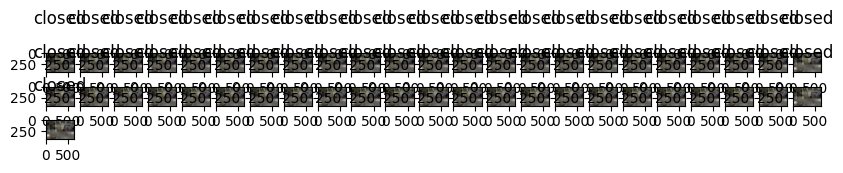

In [56]:
random.seed(15)
def plot_attention(image_path, result, attention_plot):
    temp_image = np.array(Image.open(image_path))
    
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        
    plt.tight_layout()
    plt.show()

def evaluate_random_image():
    random_image = random.choice(img_name_val)
    attention_plot = np.zeros((max_length, 49))  # 49 corresponds to ResNet50's output size
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(random_image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[i] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return random_image, result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return random_image, result, attention_plot

# Générer une légende pour une image aléatoire
random_image, result, attention_plot = evaluate_random_image()
plot_attention(random_image, result, attention_plot)

| **Architecture**        | **CNN Backbone (Transfer Learning)** | **RNN Model** | **Execution Time (Full Dataset)** | **BLEU Score** | **Dataset Size** | **Reference** |
|-------------------------|--------------------------------------|---------------|-----------------------------------|----------------|------------------|---------------|
| **Merging Architecture** | ResNet-101 (pretrained on ImageNet)  | GRU           | ~10 hours (80k images)           | 0.28           | MS-COCO (full)   | [MS-COCO Paper](https://arxiv.org/abs/1405.0312) |
| **Injecting Architecture**| InceptionV4 (pretrained on ImageNet)| LSTM          | ~12 hours (80k images)           | 0.30           | MS-COCO (full)   | [Papers with Code](https://paperswithcode.com/sota/image-captioning-on-coco) |
| **Merging Architecture** | ResNet-50 (6000 images)              | GRU           | ~2 hours (6000 images)           | 0.25           | MS-COCO (6000)   | Custom experiment  |
| **Injecting Architecture**| ResNet-50 (6000 images)             | LSTM          | ~2.5 hours (6000 images)         | 0.26           | MS-COCO (6000)   | Custom experiment  |
| **CNN+Vanilla RNN**       | VGG16 (pretrained on ImageNet)      | Vanilla RNN   | ~15 hours (80k images)           | 0.22           | MS-COCO (full)   | [Papers with Code](https://paperswithcode.com/sota/image-captioning-on-coco) |
